In [1]:
import pathlib

import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from matplotlib.animation import PillowWriter
import scienceplots
plt.style.use(['science', 'notebook'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
device

device(type='cpu')

In [3]:
n_particles = 1_000
r = torch.rand((2,n_particles)).to(device)

In [4]:
ids = torch.arange(n_particles)

In [5]:
ids_pairs = torch.combinations(ids,2).to(device)

In [6]:
def get_deltad2_pairs(r, ids_pairs):
    dx = torch.diff(torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T).squeeze()
    dy = torch.diff(torch.stack([r[1][ids_pairs[:,0]], r[1][ids_pairs[:,1]]]).T).squeeze()
    return dx**2 + dy**2

def compute_new_v(v1, v2, r1, r2):
    v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
    v2new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)
    return v1new, v2new

def motion(r, v, id_pairs, ts, dt, d_cutoff):
    rs = torch.zeros((ts, r.shape[0], r.shape[1])).to(device)
    vs = torch.zeros((ts, v.shape[0], v.shape[1])).to(device)
    # Initial State
    rs[0] = r
    vs[0] = v
    for i in range(1,ts):
        ic = id_pairs[get_deltad2_pairs(r, ids_pairs) < d_cutoff**2]
        v[:,ic[:,0]], v[:,ic[:,1]] = compute_new_v(v[:,ic[:,0]], v[:,ic[:,1]], r[:,ic[:,0]], r[:,ic[:,1]])
        
        v[0,r[0]>1] = -torch.abs(v[0,r[0]>1])
        v[0,r[0]<0] = torch.abs(v[0,r[0]<0])
        v[1,r[1]>1] = -torch.abs(v[1,r[1]>1])
        v[1,r[1]<0] = torch.abs(v[1,r[1]<0])
        
        r = r + v*dt
        rs[i] = r
        vs[i] = v
    return rs, vs

In [7]:
ixr = r[0]>0.5 #right
ixl = r[0]<=0.5 #left

v = torch.zeros((2,n_particles)).to(device)
v[0][ixr] = -100
v[0][ixl] = 100

In [8]:
radius = 0.005
rs, vs = motion(r, v, ids_pairs, ts=1000, dt=0.000008, d_cutoff=2*radius)

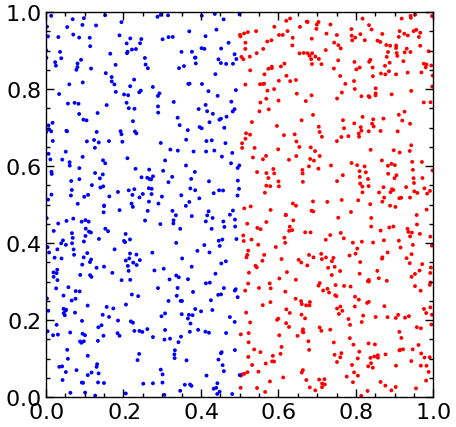

In [9]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
xred, yred = rs[0][0][ixr], rs[0][1][ixr]
xblue, yblue = rs[0][0][ixl],rs[0][1][ixl]
circles_red = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xred,yred)]
circles_blue = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xblue,yblue)]
cred = matplotlib.collections.PatchCollection(circles_red, facecolors='red')
cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors='blue')
ax.add_collection(cred)
ax.add_collection(cblue)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


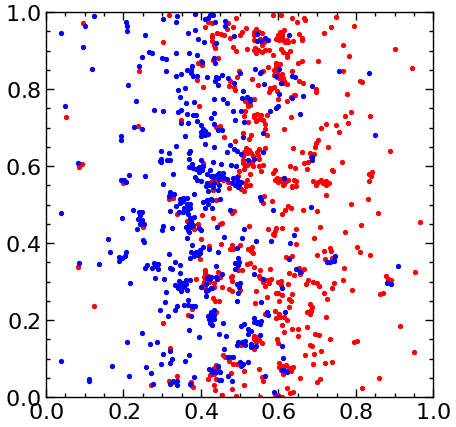

In [10]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.clear()
vmin = 0
vmax = 1
ax.set_xlim(0,1)
ax.set_ylim(0,1)
markersize = 2 * radius * ax.get_window_extent().width  / (vmax-vmin) * 72./fig.dpi
red, = ax.plot([], [], 'o', color='red', markersize=markersize)
blue, = ax.plot([], [], 'o', color='blue', markersize=markersize)

def animate(i):
    xred, yred = rs[i][0][ixr].cpu(), rs[i][1][ixr].cpu()
    xblue, yblue = rs[i][0][ixl].cpu(),rs[i][1][ixl].cpu()
    red.set_data(xred, yred)
    blue.set_data(xblue, yblue)
    return red, blue

# writer = animation.FFMpegWriter(fps=30)
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50, blit=True)
path = pathlib.Path('./ani3.gif')
ani.save(path, dpi=100)